# **Chapter 3: Intensity transformations and spatial filtering**

We begin by importing the necessary libraries, and reading the example image that can be downloaded from this [link](https://drive.google.com/file/d/1436GI0TGD-XVtRB3K1oULjBkl8vET9-v/view?usp=sharing). It provides the base image on which all later transformations and processing examples will be demonstrated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=[10,6]

In [2]:
I = io.imread('watch.jpg')

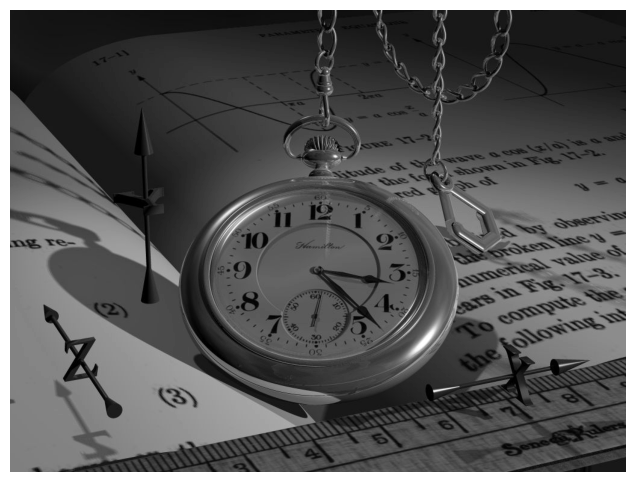

In [4]:
plt.imshow(I)
plt.axis('off');

## Negative image
Next, we create the negative of the original image by inverting all pixel values using the formula N = 255 - I. This operation reverses intensity levels, producing an image where bright areas become dark and vice versa, illustrating the concept of intensity complementation.

In [5]:
N = 255 - I

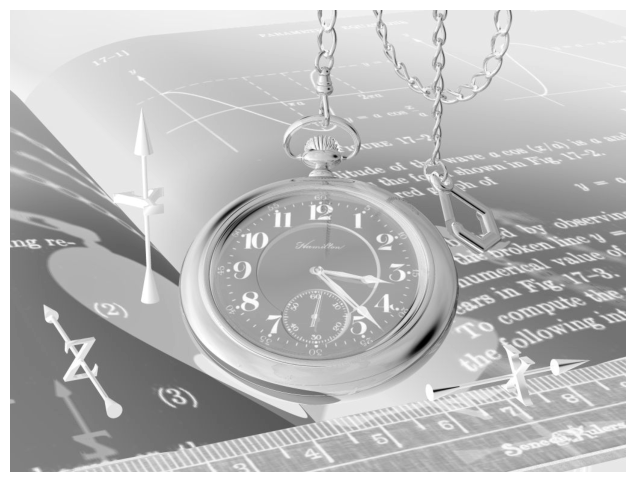

In [6]:
plt.imshow(N)
plt.axis('off');

## Logarithmic transformation
Here we apply a logarithmic transformation to the image using L = log(I + 1.0). This enhances darker regions while compressing higher intensities, helping reveal details in shadowed areas that might otherwise be hidden. Note that the constant 1.0 is added to avoid logarithm of 0 and converting the image to the floating point representation.

In [7]:
L = np.log(I + 1.0)

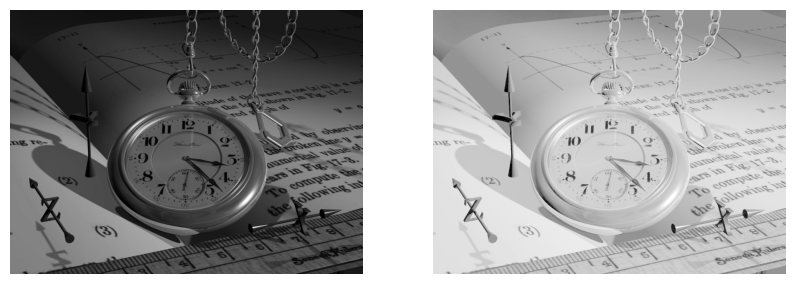

In [8]:
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(L)
plt.axis('off');

## Power-law transformation
In this part, we perform a gamma correction $P = I^{0.5}$ to demonstrate how nonlinear transformations can adjust image brightness and contrast. By using a gamma value less than one, the midtones are brightened, showing how power-law transformations reshape intensity distributions. 

In [9]:
P = I**0.5

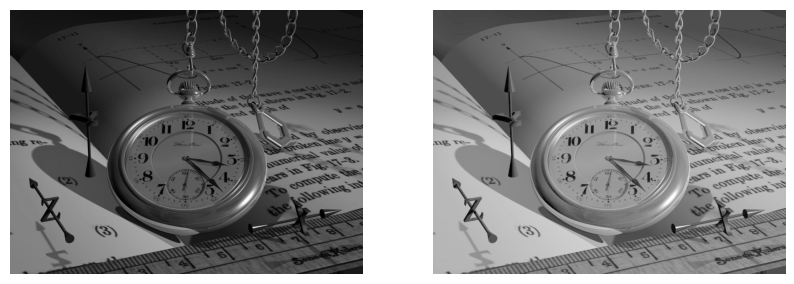

In [10]:
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(P)
plt.axis('off');

## Contrast-stretching

This section builds a piecewise-linear mapping function that stretches contrast over selected intensity ranges. Using interpolation between chosen control points, we remap pixel values to improve visibility of details in specific parts of the intensity spectrum.

Let's define a piecewise linear transformation, where 0 maps to 0, 150 maps to 250, and 255 maps to 255. We implement it using linear interpolation and a lookup table.

In [11]:
r=np.array((0,150,255))
s=np.array((0,250,255))

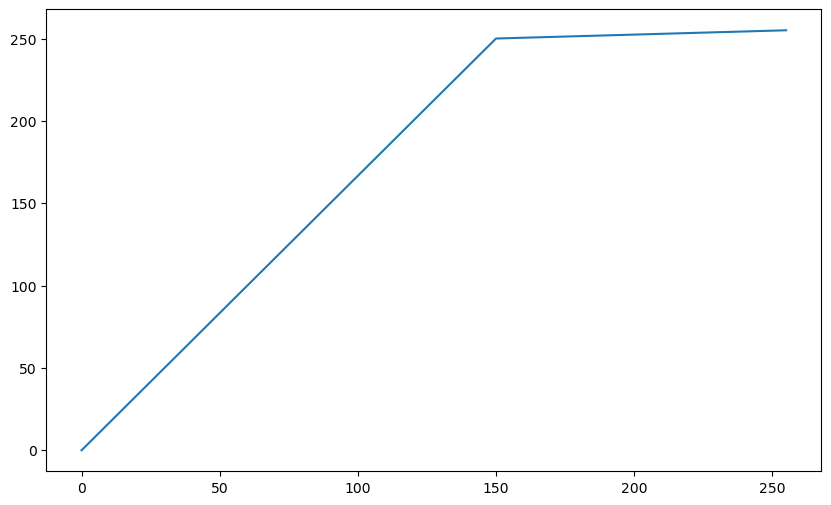

In [12]:
plt.plot(r,s)

In [13]:
x = np.arange(256)

In [14]:
T = np.interp(x,r,s).astype('uint8')

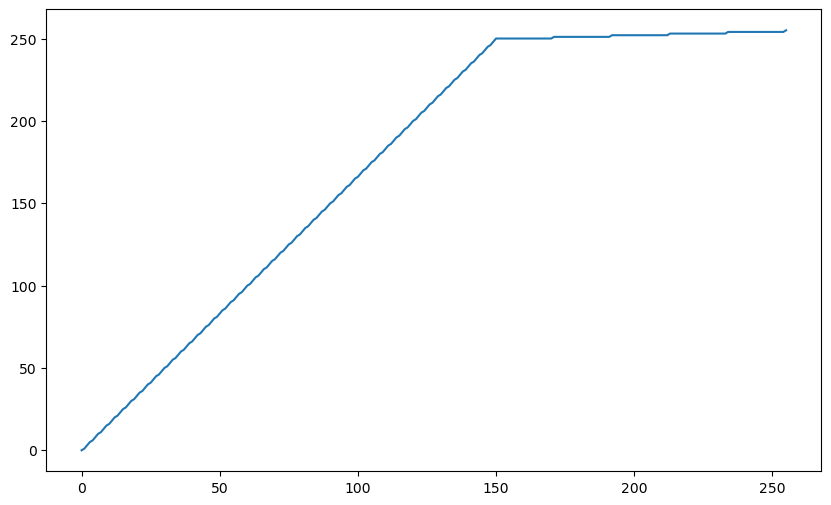

In [15]:
plt.plot(x,T)

In [16]:
C = T[I]

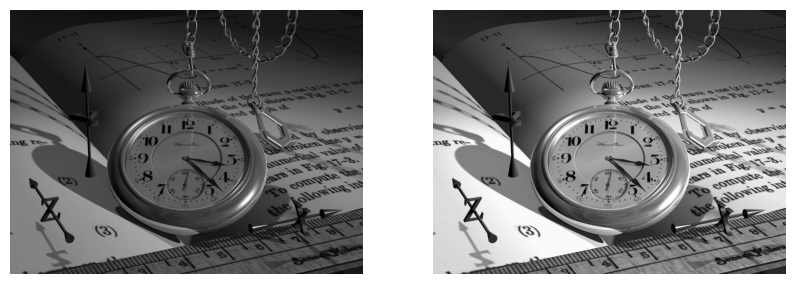

In [17]:
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(C)
plt.axis('off');

## Bit-plane slicing
Here we decompose the image into its constituent bit-planes, revealing how each bit contributes to the overall appearance. Visualizing the planes separately shows the hierarchical importance of bits in representing intensity information.

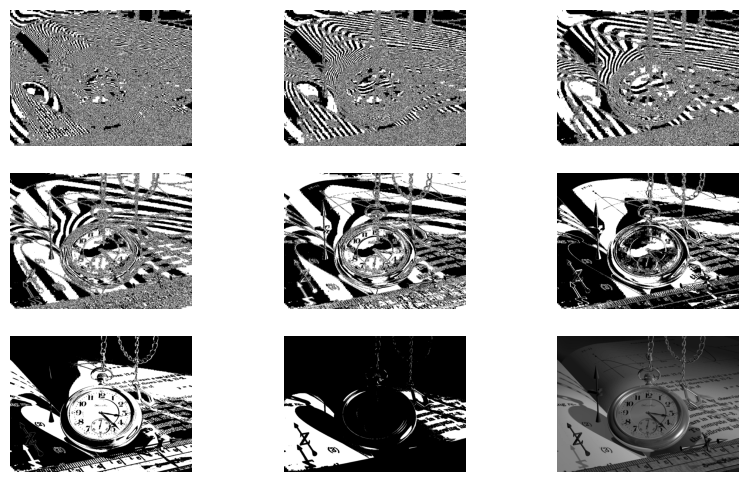

In [18]:
for i in range(8):
    plt.subplot(3,3,i+1)
    B = np.bitwise_and(I,2**i)
    plt.imshow(B)
    plt.axis('off');
plt.subplot(3,3,9)
plt.imshow(I);
plt.axis('off');

## Histogram equalization
We now compute the image histogram and cumulative distribution function to perform histogram equalization. This technique redistributes intensity levels to achieve a more uniform histogram, enhancing contrast particularly in low-contrast images.

First we extract the image histogram with the function available in `scikit-image` and visualize it.

In [19]:
from skimage.exposure import histogram

In [20]:
h, b = histogram(I)

<BarContainer object of 256 artists>

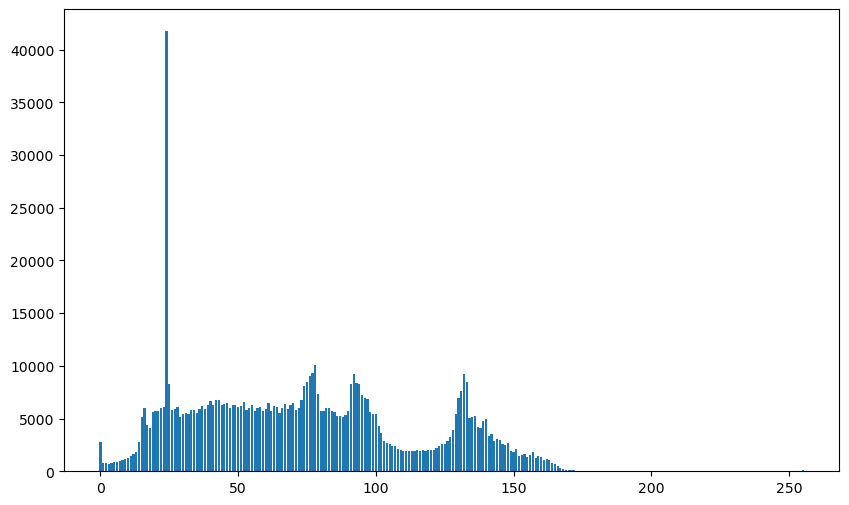

In [21]:
plt.bar(b,h)

We then implement histogram equalization using the equation given in the lecture slides and a lookup table.

In [22]:
T = (255*np.cumsum(h/sum(h))).astype('uint8')

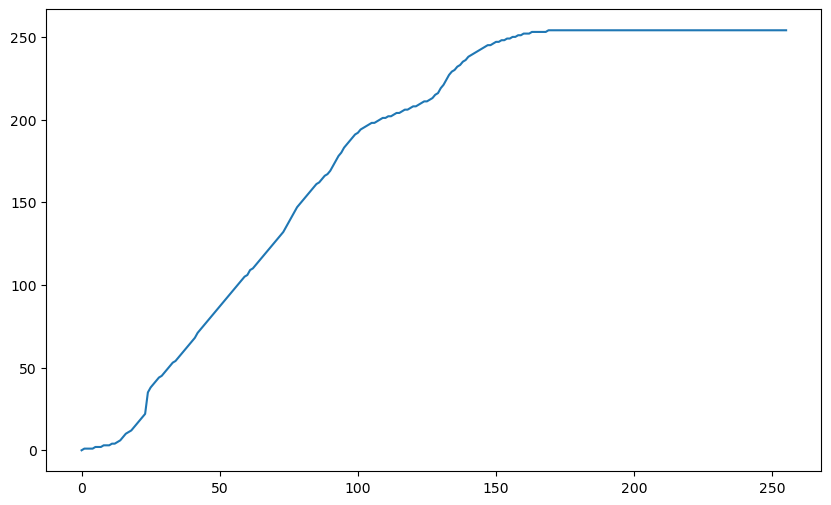

In [23]:
plt.plot(b,T)

In [24]:
E = T[I]

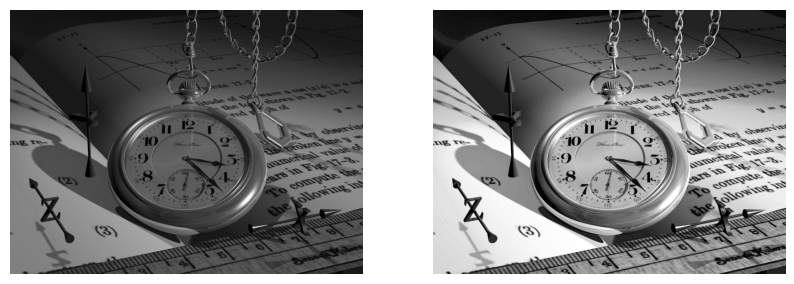

In [25]:
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(E)
plt.axis('off');

We also visualize the histograms of the original and the resulting image.

In [26]:
he, be = histogram(E)

<BarContainer object of 255 artists>

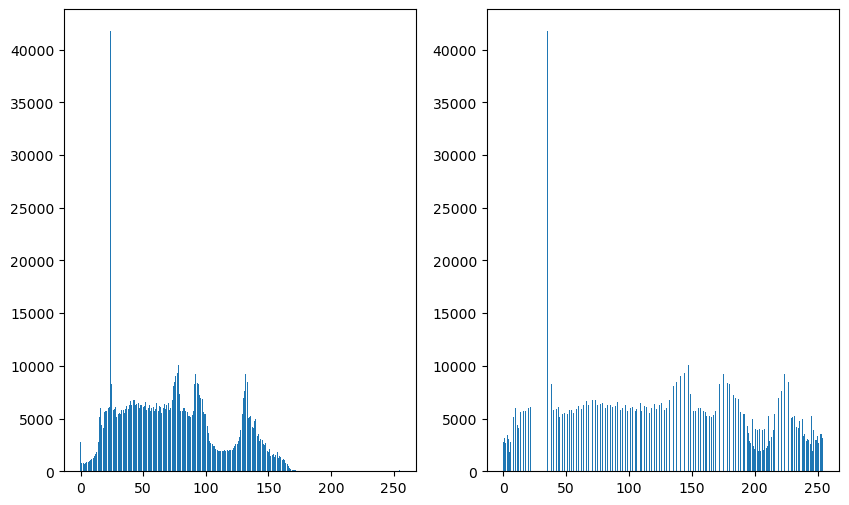

In [27]:
plt.subplot(1,2,1)
plt.bar(b,h)
plt.subplot(1,2,2)
plt.bar(be,he)

## Histogram specification

This section modifies the image so that its histogram matches a target distribution. By defining a desired histogram and mapping intensities accordingly, we demonstrate how histogram specification can control the tonal characteristics of an image.

We specify the desired histogram using a piecewise linear function $s=p(z)$ where $p(0)=1$, $p(150-)=1$, $p(150+)=2$, and $p(255)=2$. We use linear interpolation to get the histogram bins for all values $[0,255]$.

In [28]:
r = np.array((0,150,150,255))
s = np.array((1,1,2,2))

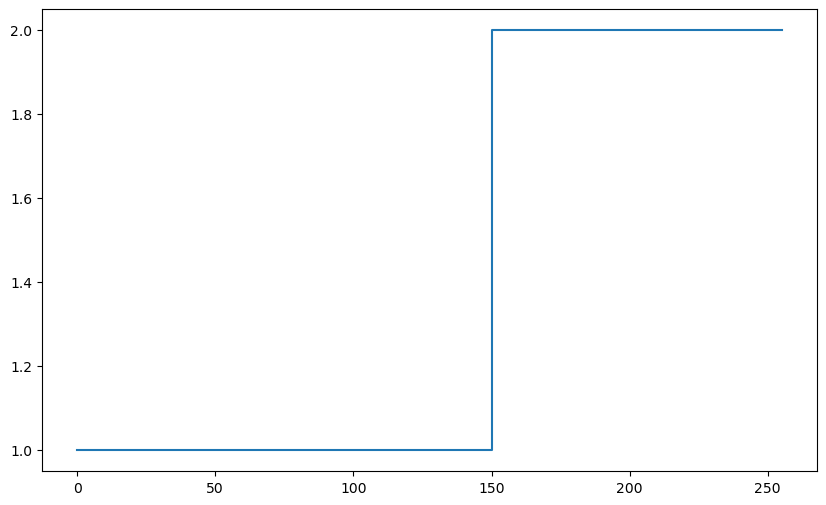

In [29]:
plt.plot(r,s)

In [30]:
hs = np.interp(x,r,s)

<BarContainer object of 256 artists>

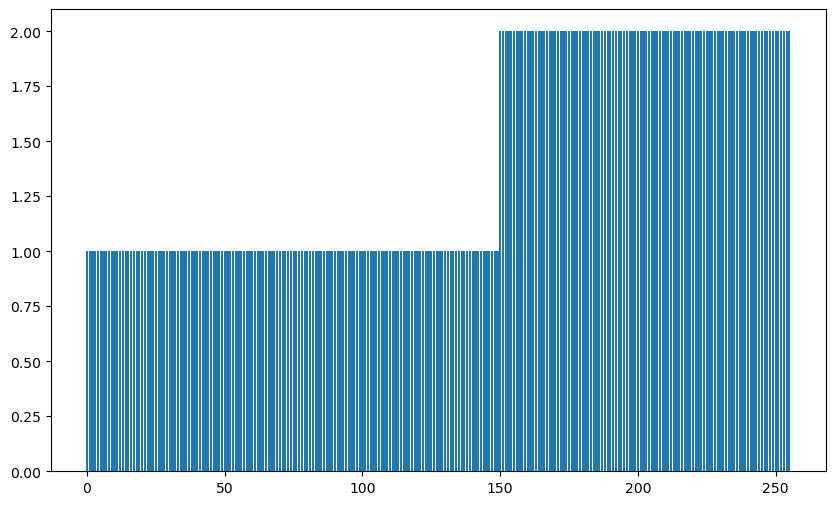

In [31]:
plt.bar(x,hs)

We compute the transformation $G(z)$ needed to perform histogram equalization.

In [32]:
G = (255*np.cumsum(hs/sum(hs))).astype('uint8')

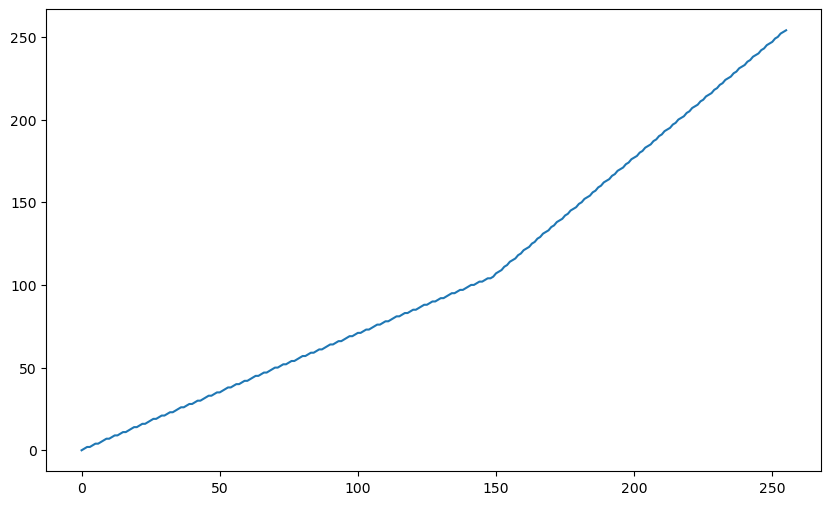

In [33]:
plt.plot(x,G)

Next, the inverse transformation $G^{-1}(s)$ is determined using linear interpolation.

In [34]:
iG = np.interp(x,G,x)

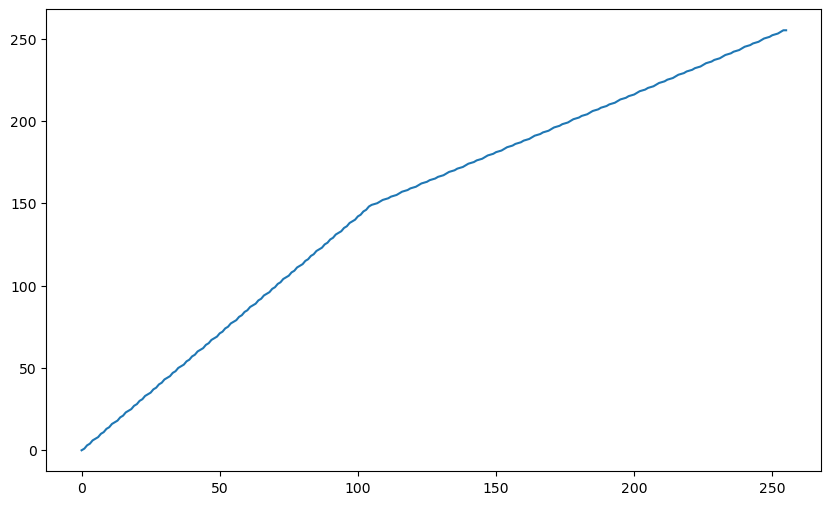

In [35]:
plt.plot(x,iG)

The inverse transformation is applied to the histogram equalized image.

In [36]:
S = iG[E]

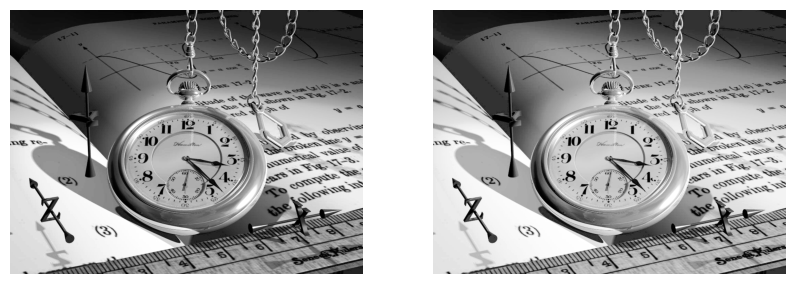

In [37]:
plt.subplot(1,2,1)
plt.imshow(E)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(S)
plt.axis('off');

The histogram of the resulting image is compared to the histogram of the image that was previously histogram equalized.

In [38]:
ht, bt = histogram(S)

<BarContainer object of 256 artists>

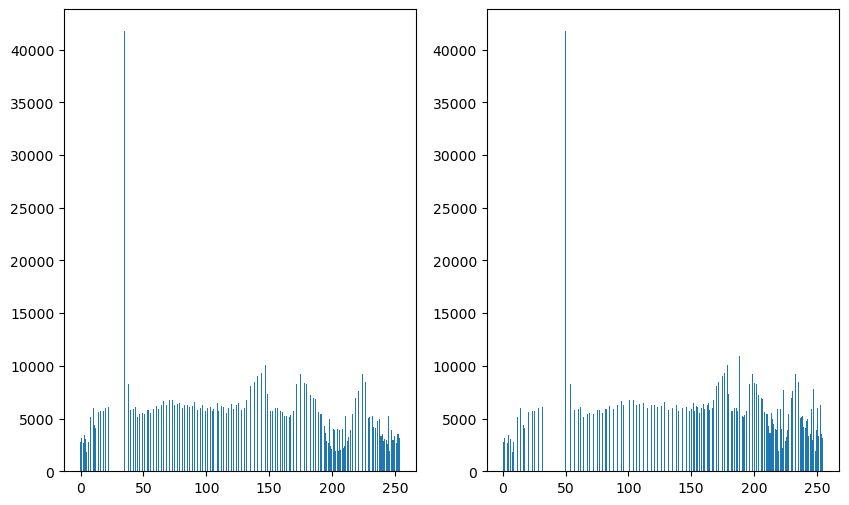

In [39]:
plt.subplot(1,2,1)
plt.bar(be,he)
plt.subplot(1,2,2)
plt.bar(bt,ht)

Finally, we note that histogram equalization has been implemented in the `scikit-image` package. When we compare its result to the one obtained above, we observe that they are identical.

In [40]:
from skimage.exposure import equalize_hist

In [41]:
Q = equalize_hist(I)

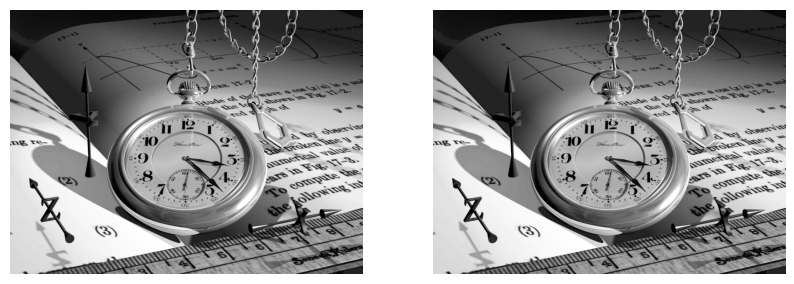

In [42]:
plt.subplot(1,2,1)
plt.imshow(E)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(Q)
plt.axis('off');

## Convolution
Next, we introduce spatial filtering by convolving the image with a simple averaging kernel. This process smooths the image and reduces noise, illustrating the principle of low-pass filtering.

Let's implement $7 \times 7$ average filtering using 2-D convolution and a mask, and apply it to the histogram equalized image.

In [43]:
from scipy.ndimage import convolve

In [44]:
avg = np.ones((7,7))/49

In [45]:
print(avg)

[[0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
  0.02040816]
 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
  0.02040816]
 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
  0.02040816]
 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
  0.02040816]
 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
  0.02040816]
 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
  0.02040816]
 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
  0.02040816]]


In [46]:
B = convolve(Q,avg)

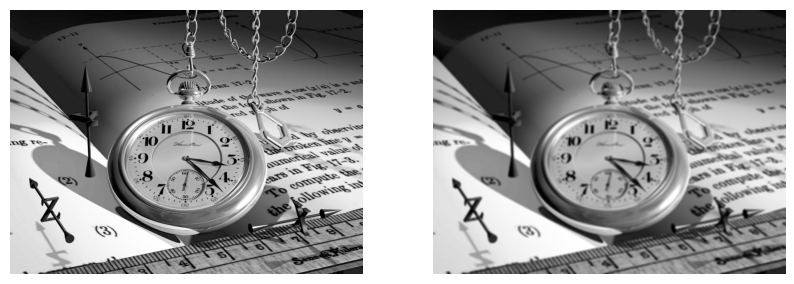

In [47]:
plt.subplot(121)
plt.imshow(Q)
plt.axis('off');
plt.subplot(122)
plt.imshow(B)
plt.axis('off');

## Gaussian filtering
Here, we apply a Gaussian filter to blur the image in a more natural way than simple averaging. The Gaussian kernel gives more weight to nearby pixels, providing smoother results while preserving overall structure.

We use the filter implementations available in the `scikit-image` package.

In [48]:
from skimage import filters

In [49]:
G = filters.gaussian(Q,3)

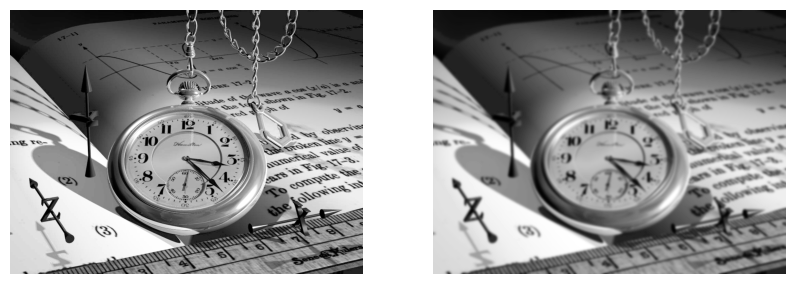

In [50]:
plt.subplot(121)
plt.imshow(Q)
plt.axis('off');
plt.subplot(122)
plt.imshow(G)
plt.axis('off');

## Median filtering
In this step, we use a median filter. Unlike linear filters, the median filter preserves edges effectively while removing isolated intensity spikes.

In [51]:
M = filters.median(Q,np.ones((7,7)))

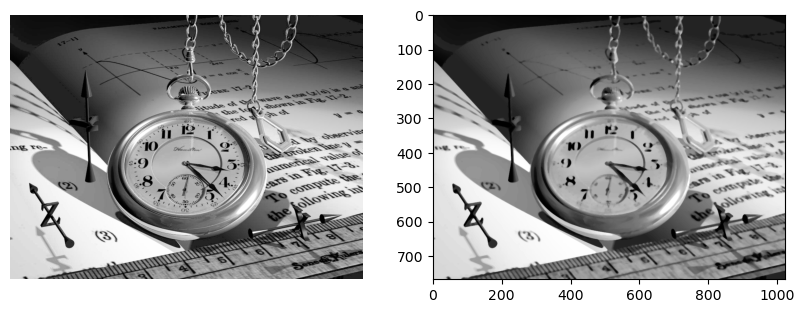

In [52]:
plt.subplot(121)
plt.imshow(Q)
plt.axis('off');
plt.subplot(122)
plt.imshow(M)

## Sharpening
This section demonstrates image sharpening using a Laplacian filter. By subtracting the Laplacian from the original image, we enhance edges and fine details, highlighting how high-pass filtering can emphasize structure.

To visualize the effect of sharpening, we extract a small patch from the original image and resize it by a factor of 4.

In [53]:
J = Q[300:400,500:600]

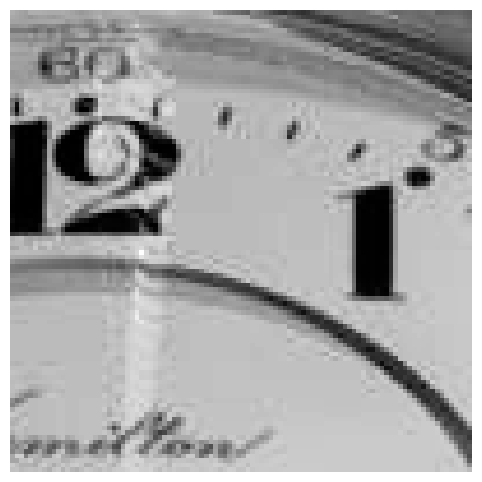

In [54]:
plt.imshow(J)
plt.axis('off');

In [55]:
from skimage.transform import rescale

In [56]:
K = rescale(J,4)

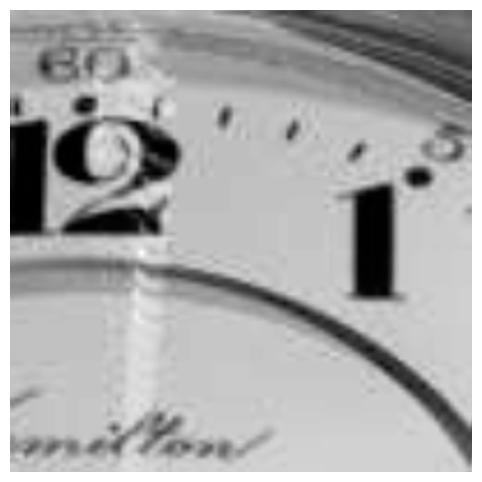

In [57]:
plt.imshow(K)
plt.axis('off');

In [58]:
K.shape

(400, 400)

Then we implement sharpening using a Laplacian filter and apply it to the resized image.

In [59]:
lap = np.ones((3,3))
lap[1,1] = -8

In [60]:
print(lap)

[[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]


In [61]:
L = convolve(K,lap)

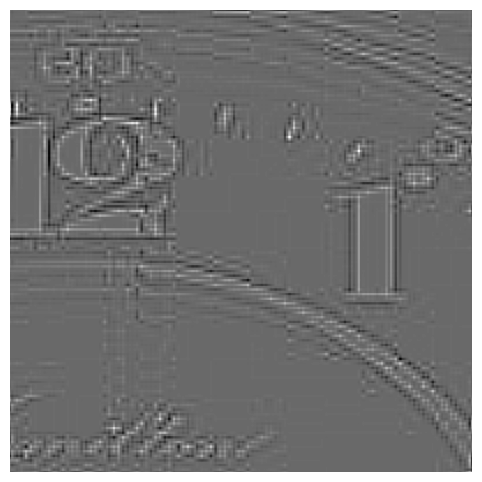

In [62]:
plt.imshow(L)
plt.axis('off');

In [63]:
S = np.clip(K-L,0,1)

We observe that the result is slightly sharper than the original one but also more noisy.

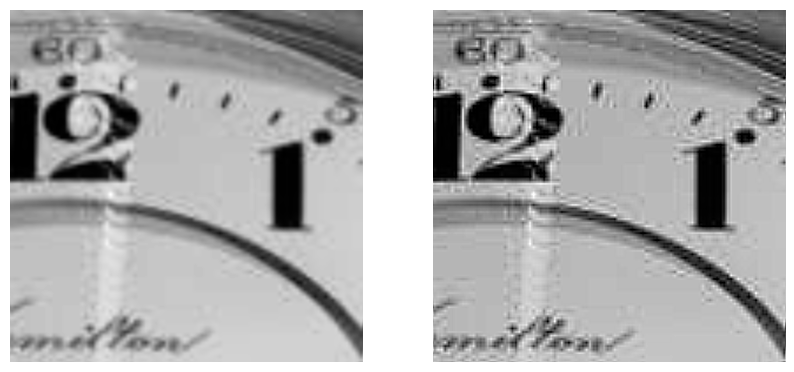

In [64]:
plt.subplot(121)
plt.imshow(K)
plt.axis('off');
plt.subplot(122)
plt.imshow(S)
plt.axis('off');

## High-boost filtering
We extend sharpening with high-boost filtering, which amplifies the high-frequency details by adding a scaled version of the unsharp mask back to the image. This method allows fine control over the amount of sharpening applied.

In the following, the mask is implemented by subtracting Gaussian filtered image from the original image. The coefficient $k$ is set to 2 in this case.

In [65]:
B = filters.gaussian(K,2)

In [66]:
M = K-B

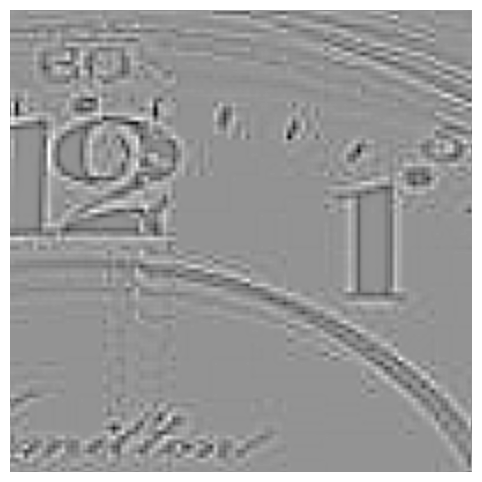

In [67]:
plt.imshow(M)
plt.axis('off');

In [68]:
N = np.clip(K + 2*M,0,1)

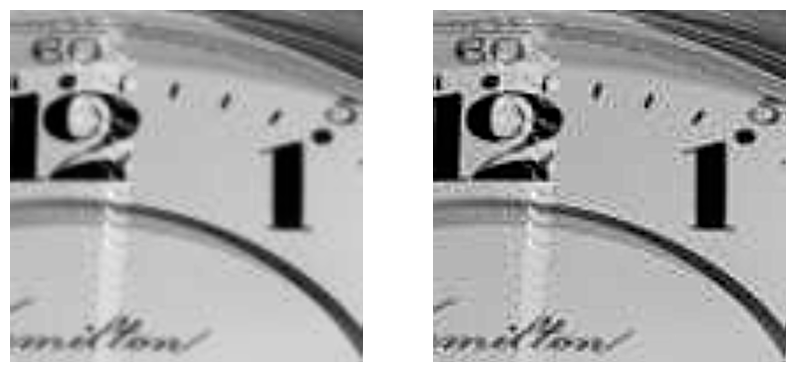

In [69]:
plt.subplot(121)
plt.imshow(K)
plt.axis('off');
plt.subplot(122)
plt.imshow(N)
plt.axis('off');

## Gradient
Finally, we compute the image gradient using Sobel operators in both the horizontal and vertical directions.

In [70]:
gx = filters.sobel_h(Q)
gy = filters.sobel_v(Q)

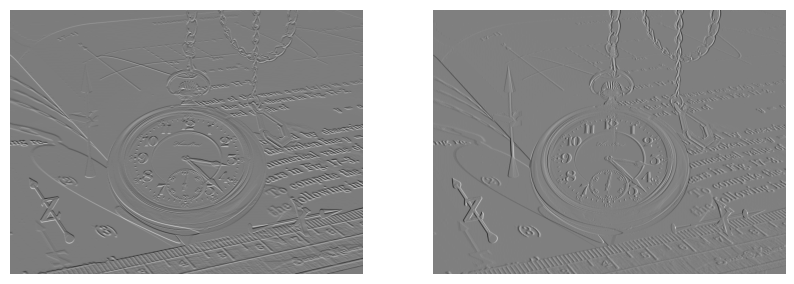

In [71]:
plt.subplot(121)
plt.imshow(gx)
plt.axis('off');
plt.subplot(122)
plt.imshow(gy)
plt.axis('off');

The resulting magnitude and direction maps reveal the locations and orientations of edges, providing a foundation for edge detection and feature extraction.

In [72]:
G = np.sqrt(gx**2 + gy**2)

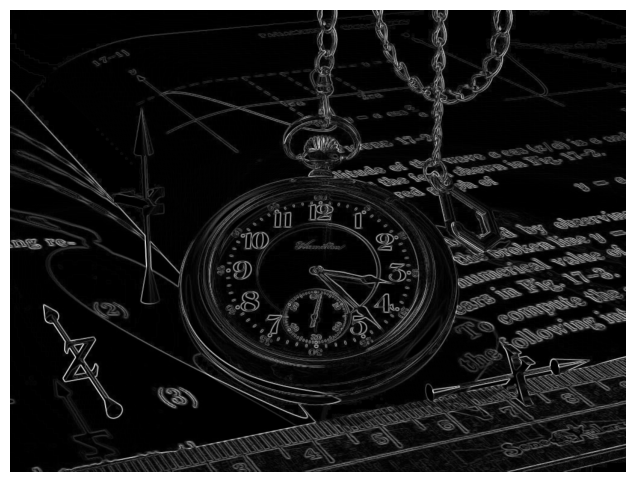

In [73]:
plt.imshow(G)
plt.axis('off');

In [74]:
A = np.arctan2(gy,gx)

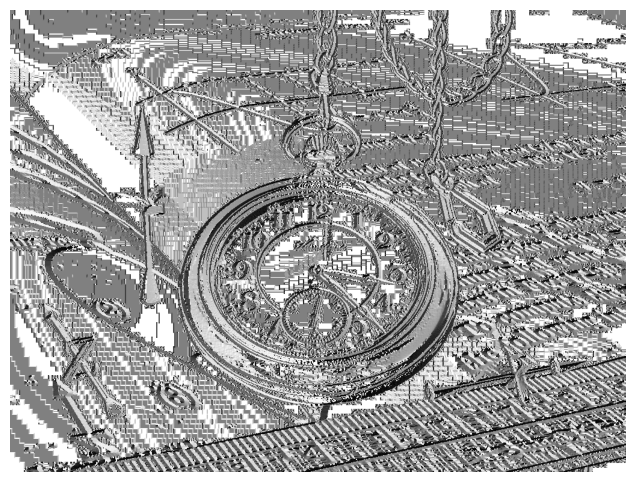

In [75]:
plt.imshow(A)
plt.axis('off');